In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
import nltk
from nltk.corpus import stopwords
import re
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета

##### Набор данных содержит отзывы на фильмы и оценки "positive" или "negative" с сайта IMDB. Необходимо на основе отзывов научиться предсказывать оценки.

In [2]:
df = pd.read_csv('IMDB Dataset.csv.zip', compression='zip')

In [3]:
# Датасет содержит 2 признака - отзыв и оценка
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
# Все признаки текстовые, всего 50000 объектов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# Пропусков нет
df.isnull().sum().sort_values(ascending=False)

sentiment    0
review       0
dtype: int64

In [6]:
# Количество позитивных и негативных оценок ровно по половине в датасете
df.groupby('sentiment').size() 

sentiment
negative    25000
positive    25000
dtype: int64

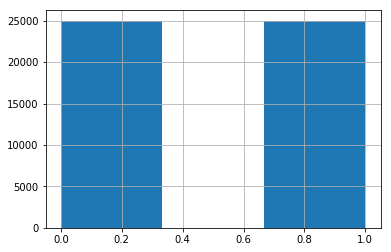

In [7]:
# Целевая переменная полностью сбалансирована
df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).hist(bins=3)
plt.show()

In [8]:
# Создадим целевую переменную
target = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

##### Создание необходимых классов и pipeline:

In [9]:
class TextPrep():
    """Класс очистки текста от переносов и приведение в нижний регистр"""
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.X = X
        self.X = self.X.drop('sentiment', axis=1)        
        self.X['review'] = self.X['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
        return self.X
    
class Stemmer():
    """Класс стемминга"""
    def fit(self, X, y=None): 
        return self
    def transform(self, X, y=None):
        self.X = X
        self.stop = stopwords.words('english')
        self.stemmer = nltk.stem.snowball.EnglishStemmer('english')
        self.X.review = self.X.review.apply(lambda x: ' '.join([self.stemmer.stem(word) for word in x.split(' ') if word not in self.stop]))
        return self.X.review

In [10]:
textprep = TextPrep() # Экземпляр очистки текста
stemmer = Stemmer() # Экземпляр стемминга слов текста

# Экземпляр tf-idf векторайзера
tf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), norm=None)

# Создаем pipeline препроцессинга
prep = Pipeline([
    ("textprep", textprep),
    ("stemmer", stemmer)
])

# На выходе будет series, как вариант итерируемого объекта для подачи его на преобразование tf-idf
prep.fit_transform(df).shape

(50000,)

In [11]:
LR = LogisticRegression() # Экземпляр лог. регрессии

# Создаем pipeline модели, который состоит из tf-idf и лог регресии - для удобства подбора параметров
model = Pipeline([
    ("tf_vectorizer", tf_vectorizer),
    ("modelling", LR)
])

# Итоговый pipeline: преобразование + модель
pipe = Pipeline([
    ("preprocessing", prep),
    ("model", model)
])
# Параметры, которые есть у pipeline модели
pipe['model'].get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tf_vectorizer', 'modelling', 'tf_vectorizer__analyzer', 'tf_vectorizer__binary', 'tf_vectorizer__decode_error', 'tf_vectorizer__dtype', 'tf_vectorizer__encoding', 'tf_vectorizer__input', 'tf_vectorizer__lowercase', 'tf_vectorizer__max_df', 'tf_vectorizer__max_features', 'tf_vectorizer__min_df', 'tf_vectorizer__ngram_range', 'tf_vectorizer__norm', 'tf_vectorizer__preprocessor', 'tf_vectorizer__smooth_idf', 'tf_vectorizer__stop_words', 'tf_vectorizer__strip_accents', 'tf_vectorizer__sublinear_tf', 'tf_vectorizer__token_pattern', 'tf_vectorizer__tokenizer', 'tf_vectorizer__use_idf', 'tf_vectorizer__vocabulary', 'modelling__C', 'modelling__class_weight', 'modelling__dual', 'modelling__fit_intercept', 'modelling__intercept_scaling', 'modelling__l1_ratio', 'modelling__max_iter', 'modelling__multi_class', 'modelling__n_jobs', 'modelling__penalty', 'modelling__random_state', 'modelling__solver', 'modelling__tol', 'modelling__verbose', 'modelling__warm_

##### Подбор параметров и обучение модели:

In [12]:
# Разобьём выборку на тренировачную и тестовую в пропорции 70/30
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.30)

In [13]:
# Заранее сделаем препроцессинг тренировачной выборки для экономии времени на подборе параметров
X_train_prep = pipe['preprocessing'].fit_transform(X_train)

In [14]:
%%time
# Подберем вид регулиризации, коэффициент при ней и варианты обработки текста
param_grid = {
    'modelling__penalty' : ['l1', 'l2'],
    'modelling__C' : np.logspace(-2, 1, 10),
    'tf_vectorizer__ngram_range' : [(1, 2), (1, 1)],
    'tf_vectorizer__min_df' : [2, 3, 0.001],
    'tf_vectorizer__max_df' : [0.4, 0.5]
}
search = GridSearchCV(pipe['model'], param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
search.fit(X_train_prep, y_train)

Wall time: 1h 2min 51s


In [15]:
# лучшая f1 метрика лог регрессии
search.best_score_

0.9019323334447182

In [16]:
# лучшие параметры модели
search.best_params_

{'modelling__C': 0.01,
 'modelling__penalty': 'l2',
 'tf_vectorizer__max_df': 0.4,
 'tf_vectorizer__min_df': 2,
 'tf_vectorizer__ngram_range': (1, 2)}

In [17]:
# Теперь проверим качество на отложенной тестовой выборке
X_test_prep = pipe['preprocessing'].transform(X_test)
print(classification_report(y_test, search.best_estimator_.predict(X_test_prep)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      7473
           1       0.90      0.91      0.91      7527

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



#### Визуализация важности слов:

In [18]:
# Коэффициенты лог. регресси при признаках-словах
coef = search.best_estimator_['modelling'].coef_

In [19]:
# Список названий признаков-слов
feature_names = search.best_estimator_['tf_vectorizer'].get_feature_names()

In [20]:
# Датафрейм соответствия коэффициентов и слов
importance = pd.DataFrame({"importance": coef.tolist()[0]}, index=feature_names)
importance.head(10)

,importance
00,0.003706
00 agent,0.004011
00 schneider,-0.000293
000,-0.001237
001,-0.001018
002,-0.000582
002 10,-0.000598
007,-0.006721
007 movi,-0.004978
007 theme,-0.004849


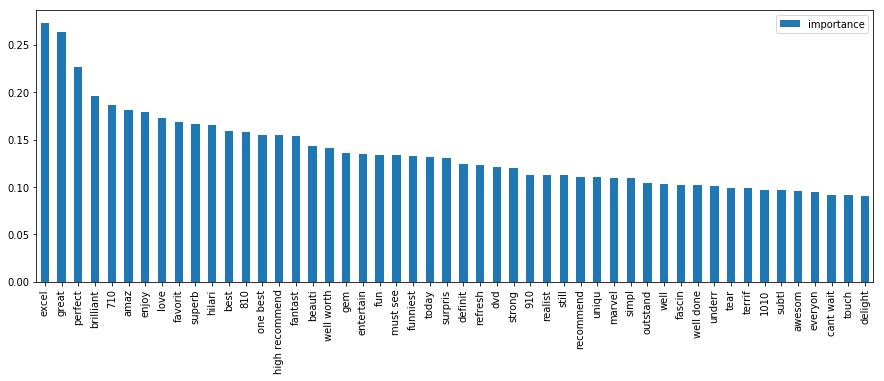

In [21]:
# 50 наиболее важных слов для позитивных отзывов
importance.sort_values(["importance"], ascending=False).head(50).plot.bar(figsize=(15, 5))
plt.show()

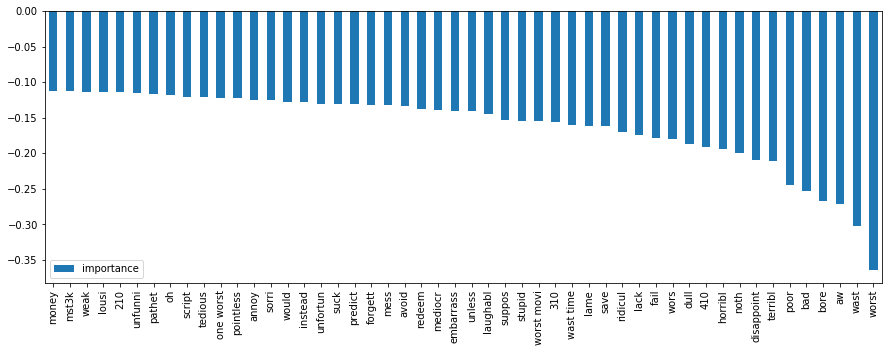

In [22]:
# 50 наиболее важных слов для негативных отзывов
importance.sort_values(["importance"], ascending=False).tail(50).plot.bar(figsize=(15, 5))
plt.show()

#### Выводы:

- Логистическая регрессия показала хорошее качество работы как на обучающей так и на тестовой выборке f1=0.90 с использованием биграмм, минимальным количеством слов встречающихся не реже, чем в двух отзывах и не чаще, чем в 50% отзывах;
- Наиболее важные слова для позитивных отзывов оказались - "excellent", "great", "perfect", "brilliant", "amazing", "enjoy", а наиболее важные слова для негативных отзывов - "worst", "waste", "away", "bored", "bad", что, действительно, говорит о логичности работы алгоритма.